In [1]:
"""
The exact formulation of the problem:
Given data going as far back as lookback timesteps (a timestep is 10 minutes)
and sampled every steps timesteps, can you predict the temperature in delay timesteps?
You’ll use the following parameter values:
- lookback = 720 — Observations will go back 5 days.
- steps = 6 — Observations will be sampled at one data point per hour.
- delay = 144 — Targets will be 24 hours in the future.
"""

'\nThe exact formulation of the problem:\nGiven data going as far back as lookback timesteps (a timestep is 10 minutes)\nand sampled every steps timesteps, can you predict the temperature in delay timesteps?\nYou’ll use the following parameter values:\n- lookback = 720 — Observations will go back 5 days.\n- steps = 6 — Observations will be sampled at one data point per hour.\n- delay = 144 — Targets will be 24 hours in the future.\n'

In [2]:
%reset
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


/Users/slechwar/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
DATA_DIR = '/Users/slechwar/dev/methods/sequences/forecasting'
TRAINING_SAMPLES = 200000

fname = os.path.join(DATA_DIR, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [4]:
%%time
def preprocessing(lines, training_samples):
    # Change all values to floats.
    # Remove 'Date Time' column from further processing.
    # Standardize the data.
    result = np.zeros((len(lines), len(header) - 1))
    for i, line in enumerate(lines):
        values = [float(x) for x in line.split(',')[1:]]
        result[i, :] = values

    mean = result[:training_samples].mean(axis=0)
    result -= mean
    std = result[:training_samples].std(axis=0)
    result /= std

    return result, mean, std

float_data, mean, std = preprocessing(lines, TRAINING_SAMPLES)

CPU times: user 2.62 s, sys: 66.4 ms, total: 2.69 s
Wall time: 2.79 s


In [5]:
'''
- data: The original array of floating-point data.
- lookback: How many timesteps back the input data should go.
- delay: How many timesteps in the future the target should be.
- min_index and max_index: Indices in the data array that delimit which timesteps
to draw from. This is useful for keeping a segment of the data for validation
and another for testing.
- shuffle: Whether to shuffle the samples or draw them in chronological order.
- batch_size: The number of samples per batch.
- step: The period, in timesteps, at which you sample data. You’ll set it to 6 in
order to draw one data point every hour.
'''
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        # Axis:
        # 0: Number of samples in the batch.
        # 1: Time axis (timestamp). Drawn data point (one hour interval).
        # 2: Features axis.
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
    
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

train_steps = (200000 - lookback)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [6]:
%%time
# Non-ML baseline to beat.
# Temperature in next 24h will be the same as temperature in current time.
# Lets calculate mean absolut error to check its performance.
# To speed things up, take onlt 1/100 of validation dataset.
def evaluate_naive_method(std):
    batch_maes = []
    for _ in range(val_steps // 100):
        samples, targets = next(val_gen)
        # Take all samples (axis 0),
        # from last period/timestamp (axis 1),
        # and feature "T (degC)" (axis 2)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    mean_batch_maes = np.mean(batch_maes)
    print('Mean MAE: {}'.format(mean_batch_maes))
    # Because the temperature data has been normalized to be
    # centered on 0 and have a standard deviation of 1, 
    # this number isn’t immediately interpretable.
    # Need to multiply with standard deviation to get interpretable value.
    print('Mean MAE (degrees Celsius): {}'.format(mean_batch_maes * std[1]))
    
evaluate_naive_method(std)

Mean MAE: 0.2848166608827257
Mean MAE (degrees Celsius): 2.521339229060914
CPU times: user 5.95 s, sys: 46.4 ms, total: 6 s
Wall time: 6.13 s


In [9]:
train_steps//batch_size

1551

In [12]:
%%time
# Basic ML approach.
# Regression model.

def regression_model():
    model = tf.keras.models.Sequential()
    # Flatten expect shape without batches.
    # Note! It will remove notion of time.
    # Here we pass (number of timeseries samples, number of featuers).
    model.add(tf.keras.layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    # Last layer without activation (typical for regression problems).
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='mae')
    model.summary()
    return model

model = regression_model()
# Bug probably...
# In order to run this, set:
# - steps_per_epoch=train_steps // batch_size,
# - validation_steps=val_steps // batch_size,
# - workers=1,
# - use_multiprocessing=False
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps // batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps // batch_size,
    workers=1,
    use_multiprocessing=False
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1551/1551 [==============================] - 22s 14ms/step - loss: 0.6609 - val_loss: 0.3212
Epoch 2/20
1551/1551 [==============================] - 23s 15ms/step - loss: 0.2500 - val_loss: 0.3275
Epoch 3/20
1551/1551 [==============================] - 21s 14ms/step - loss: 0.2289 - val_loss: 0.3205
Epoch 4/20
1551/1551 [==============================] - 22s 14ms/step - loss: 0.2159 - v

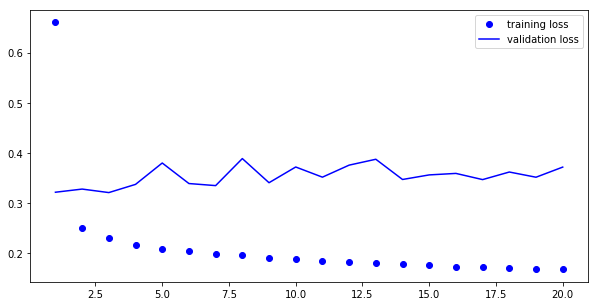

In [29]:
def plot_loss(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, 'bo', label='training loss')
    plt.plot(epochs, val_loss, 'b', label='validation loss')
    plt.legend()
    plt.show()

plot_loss(history)
# Worse than baseline for validation sample...

Epoch 1/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.1434 - val_loss: 0.3608
Epoch 2/20
1551/1551 [==============================] - 18s 12ms/step - loss: 0.1428 - val_loss: 0.3603
Epoch 3/20
1551/1551 [==============================] - 19s 12ms/step - loss: 0.1424 - val_loss: 0.3712
Epoch 4/20
1551/1551 [==============================] - 18s 12ms/step - loss: 0.1412 - val_loss: 0.3545
Epoch 5/20
1551/1551 [==============================] - 18s 12ms/step - loss: 0.1408 - val_loss: 0.3674
Epoch 6/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.1400 - val_loss: 0.4113
Epoch 7/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.1394 - val_loss: 0.3539
Epoch 8/20
1551/1551 [==============================] - 18s 11ms/step - loss: 0.1391 - val_loss: 0.3711
Epoch 9/20
1551/1551 [==============================] - 17s 11ms/step - loss: 0.1386 - val_loss: 0.3546
Epoch 10/20
1551/1551 [==============================] - 17s 11m

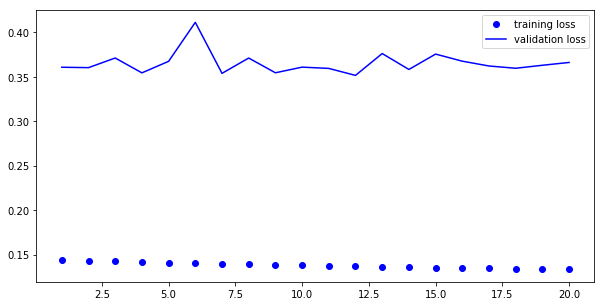

CPU times: user 8min 42s, sys: 53.2 s, total: 9min 35s
Wall time: 5min 51s


In [33]:
%%time
# Recurrent approach.
# Use Gated recurrent unit (GRU)
# Works using the same principle as LSTM
# but they’re somewhat streamlined and thus cheaper to run

def gru_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(32, input_shape=(None, float_data.shape[-1])))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
    return model
    
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps // batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps // batch_size)

plot_loss(history)